In [22]:
import numpy as np
import torch
import torchvision.transforms as T

In [23]:
def get_normalize(features: torch.Tensor):
    means = features.mean(axis = (0, 1, 2))
    stds = features.std(axis = (0, 1, 2))
    return (means, stds)

In [38]:
def get_augmentations(train: bool = True) -> T.Compose:
    
    means = (0.4914, 0.4822, 0.4465)
    stds = (0.2023, 0.1994, 0.2010)
    if train:
        return T.Compose(
            [
                T.RandomCrop(32, padding=4, padding_mode='reflect'), 
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Normalize(mean = means, std = stds)
            ]
        )
    return T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean = means, std = stds)
            ]
    )

In [25]:
from torch.utils.data import DataLoader
from torch import nn
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    predictions = []
    model.eval()
    total = 0
    correct = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        _, y_pred = torch.max(output, dim = 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
        predictions.append(y_pred)
    print(correct / total)
    return torch.cat(predictions, dim = 0)

In [26]:
from torch.utils.data import DataLoader
from torch import nn
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = loss_fn(output, y)
        total_loss += loss.item()
        _, y_pred = torch.max(output, dim = 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
    
    total_loss /= len(loader)
    test_accuracy = correct / total
    return total_loss, test_accuracy

In [27]:
def create_simple_conv_cifar():
    return nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), # 32 x 32 x 32
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.MaxPool2d(2),
        nn.Dropout(p = 0.2),
        
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), # 16 x 16 x 64
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Flatten(),
        
        nn.Linear(16 * 16 * 64, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        
        nn.Linear(1024, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p = 0.2),
        nn.ReLU(),
        
        nn.Linear(256, 10)
    )

In [28]:
from torch import nn
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1), # 32 x 32 x 64
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), # 32 x 32 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # 16 x 16 x 128
            nn.Dropout2d(p = 0.2)
        )

        
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1), # 16 x 16 x 128
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1), # 16 x 16 x 128
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), # 16 x 16 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # 8 x 8 x 256
        )
        
        self.block6 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1), # 8 x 8 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2), # 4 x 4 x 512
        )

        self.block7 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1), # 4 x 4 x 512
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.block8 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1), # 4 x 4 x 512
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.block9 = nn.Sequential(
            nn.MaxPool2d(4), # 1 x 1 x 512
            nn.Flatten(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.block1(x)

        x = self.block2(x)

        x = self.block3(x)

        x = self.block4(x) + x

        x = self.block5(x)

        x = self.block6(x)

        x = self.block7(x)

        x = self.block8(x) + x
        
        x = self.block9(x)
        return x

In [29]:
def create_advanced_skip_connection_conv_cifar():
    return MyModel()

In [30]:
def create_advanced_conv_cifar():
    return nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            #nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1), # 32 x 32 x 32
            #nn.BatchNorm2d(32),
            #nn.ReLU(),

            nn.MaxPool2d(2), # 16 x 16 x 32
            nn.Dropout2d(p = 0.2),
            
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            #nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1), # 16 x 16 x 64
            #nn.BatchNorm2d(64),
            #nn.ReLU(),

            nn.MaxPool2d(2), # 8 x 8 x 64
            nn.Dropout2d(p = 0.2),
            
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1), # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1), # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2), # 4 x 4 x 128
            nn.Dropout2d(p = 0.2),
            
            nn.Flatten(),
            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout2d(p = 0.2),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

In [31]:
from tqdm import tqdm
def train_model(model: nn.Module, loader: DataLoader, device: torch.device):
    model.train()
    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc = 'train'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        
        loss.backward()

        optimizer.step()

        _, y_pred = torch.max(output, dim = 1)
        correct += (y_pred == y).sum().item()
        total += y.size(0)

    train_loss /= len(loader)
    accuracy = correct / total
    return train_loss, accuracy

In [32]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_stats(
    train_loss: list[float],
    test_loss: list[float],
    train_accuracy: list[float],
    test_accuracy: list[float],
    title: str
):
    plt.figure(figsize = (16, 10))
    plt.title(title + ' Loss')
    plt.plot(train_loss, label = 'Train Loss')
    plt.plot(test_loss, label = 'Test Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize = (16, 10))
    plt.title(title + ' Accuracy')
    plt.plot(train_accuracy, label = 'Train Accuracy')
    plt.plot(test_accuracy, label = 'Test Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    

In [33]:
def whole_train_eval_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, train_loader, device)
        valid_loss, valid_accuracy = evaluate(model, test_loader, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()
        plot_stats(train_loss_history, valid_loss_history, 
                   train_accuracy_history, valid_accuracy_history, 
                   title
                  )
        # scheduler.step()

In [34]:
from torchvision.datasets import CIFAR10

In [35]:
print(f"GPU доступен: {torch.cuda.is_available()}")

GPU доступен: True


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

loss_fn = nn.CrossEntropyLoss()
model = create_advanced_skip_connection_conv_cifar().to(device)
optimizer = Adam(model.parameters(), lr = 1e-3)
#scheduler = StepLR(optimizer, step_size = 25, gamma = 0.1)

train_transform = get_augmentations()
test_transform = get_augmentations(False)

dataset_train = CIFAR10('/kaggle/input/datasets/artembez/dataset', download = False, train = True, transform = train_transform)
train_loader = DataLoader(dataset_train, batch_size = 256, shuffle = True, num_workers = 4, pin_memory = True)

In [40]:
dataset_test = CIFAR10('/kaggle/input/datasets/artembez/dataset', train = False, transform = test_transform)
test_loader = DataLoader(dataset_test, batch_size = 512, shuffle = False, num_workers = 4)

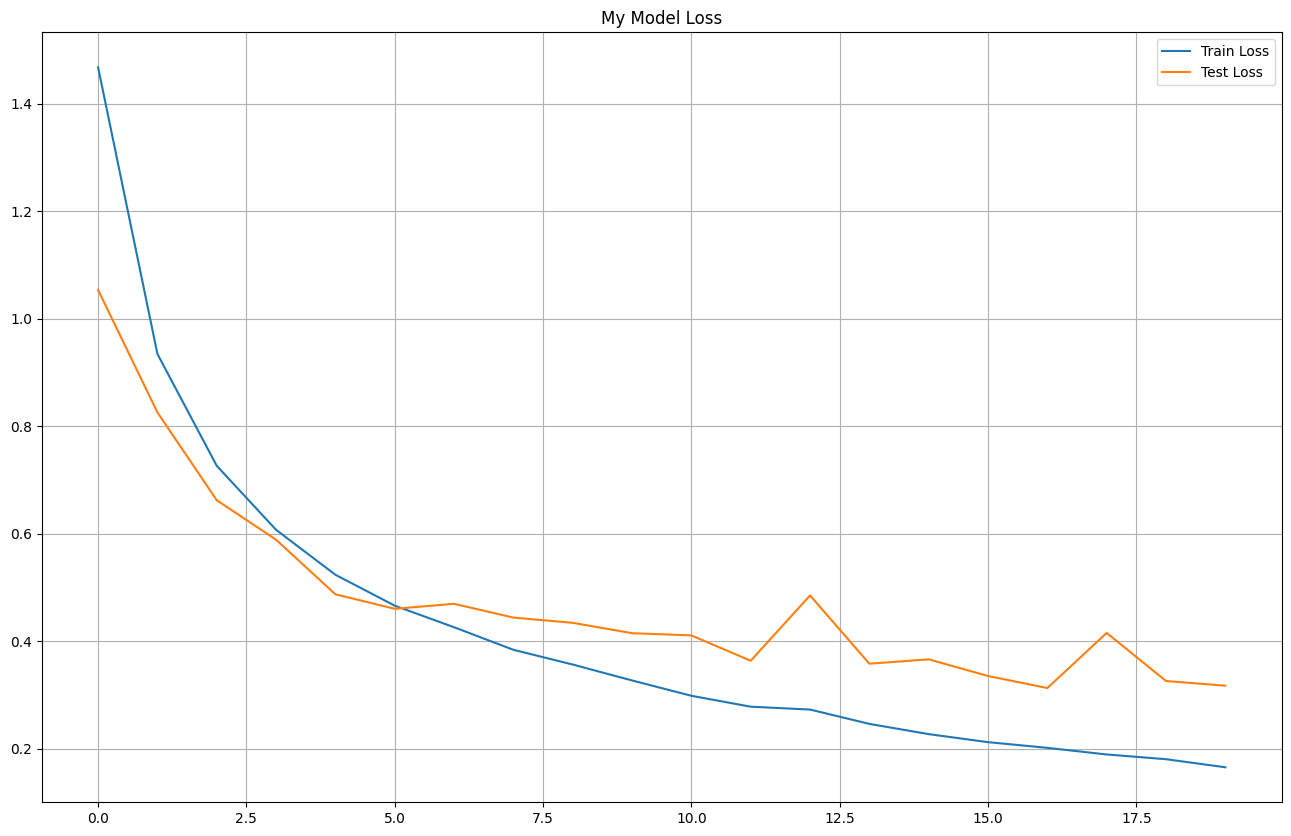

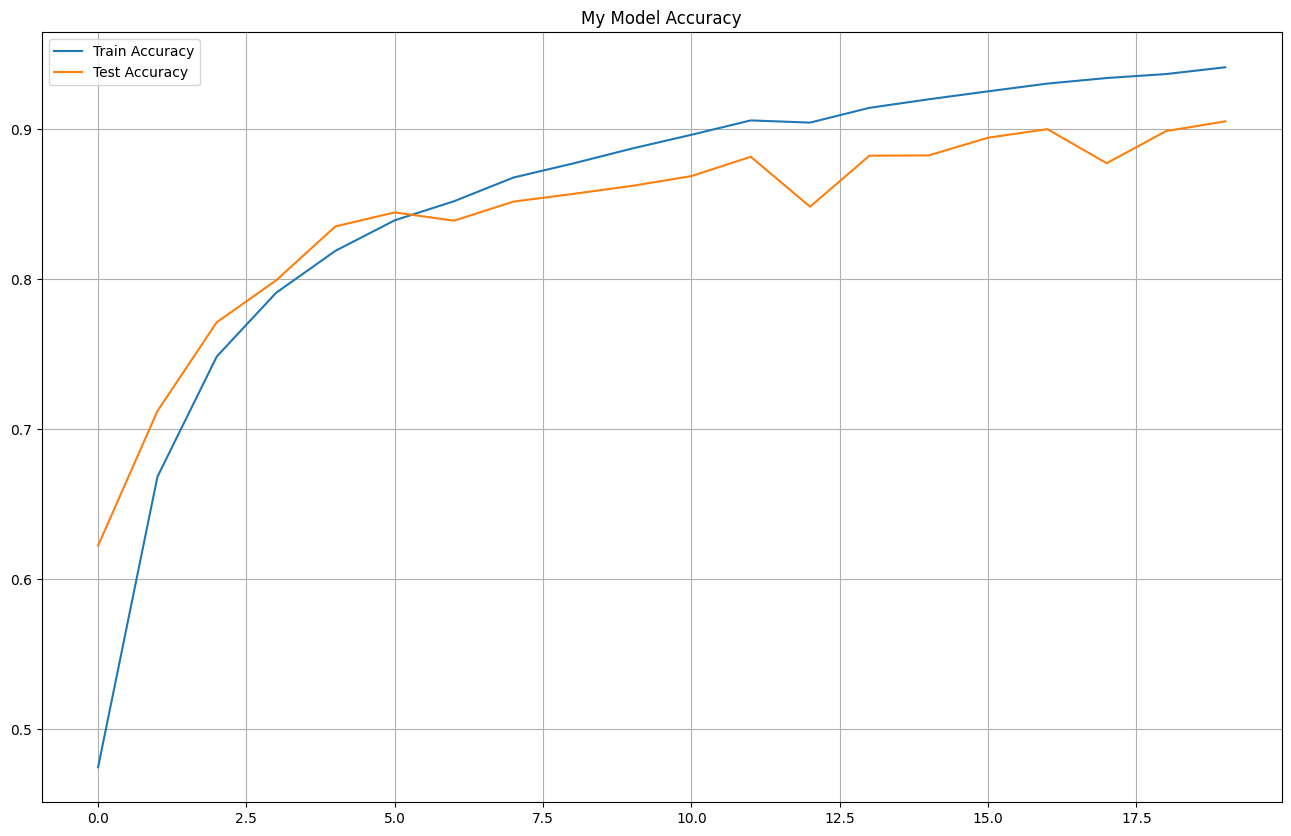

In [41]:
whole_train_eval_cycle(model, 20, 'My Model')

In [42]:
import torch
from torch import nn
from torch.utils.data import DataLoader
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.eval()
    logits_for_every_object_by_iteration = []
    with torch.no_grad():
        for iteration in range(iterations):
            logits_for_every_object = []
            for features, _ in loader:
                features = features.to(device)
                output = model(features)
                logits_for_every_object.append(output)    
            logits_for_every_object = torch.cat(logits_for_every_object, dim = 0)
            logits_for_every_object_by_iteration.append(logits_for_every_object.unsqueeze(-1))
    all_logits = torch.cat(logits_for_every_object_by_iteration, dim = -1)
    predictions = all_logits.mean(dim = -1)
    predictions = torch.argmax(predictions, dim = 1)
    return predictions

In [43]:
predictions = predict_tta(model, test_loader, device, 20)

In [44]:
torch.save(predictions, 'my_predictions.pt')